In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import torch
import numpy as np
import tifffile as tiff

from src.LRP import LayerWiseRelevancePropagation
from src.vit_mae_4_hash_bilrp import vit_base

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt


In [2]:
# TODO 
# path_to_tifs = ''
# path_to_annot_json = ''

In [3]:
# TODO set dev to your preferred device, e.g.
# dev = 'cuda:0'
# dev = 'cpu'

In [4]:
kwargs = {'img_size': 128, 'in_chans': 4, 'patch_size': 8}
backbone = vit_base(**kwargs)

In [5]:
backbone.to(dev).eval()

ckpt_path = "./weights/weights_bilrp.ckpt"
# load ckpt weights into backbone
state = torch.load(ckpt_path, map_location="cpu")["state_dict"]
ret = backbone.load_state_dict(state, strict=False)
print('Loading:', ret)


Loading: <All keys matched successfully>


In [6]:
with open(f'{path_to_annot_json}/vessels_dataset_annotations.json') as f:
    d = json.load(f)
    annotations_dict = d


def patch_name_2_img(patch_name):
    """Receive a file name (without '.tif') and return then corresponding image.

    Args:
        patch_name (str): tif file name

    Returns:
        numpy: img, img as rgb, list of coordinates
    """
    
    path_tif = f'{path_to_tifs}/{patch_name}.tif'

    img = tiff.imread(path_tif)
    img = (img-np.min(img))/(np.max(img)-np.min(img))
    img = np.flipud(img)
    img3 = img[:,:,[0,1,2]]

    geo_list = annotations_dict[patch_name]['annotations']

    coords_list = []
    for geo in geo_list:
        coord = geo['geometry']['coordinates'][0]
        coord.append(coord[0])
        coords_list.append(list(zip(*coord)))
        
        coords_list = list(map(lambda x: list(x).copy(), coords_list)) # remove yield operation

    return img, img3, coords_list


img_samples = [
    'T32TLP_20190803T103029_TCI_crop_x-1536_y-5760',
    'T32TLP_20190803T103029_TCI_crop_x-1280_y-6528'
]


In [7]:
# Load two images x1,x2
x1, _, coords1 = patch_name_2_img(img_samples[0])
x2, _, coords2 = patch_name_2_img(img_samples[1])

# NOTE here we rotate images
x1 = np.rot90(x1, -1, (1,0))
x2 = np.rot90(x2, -1, (1,0))

# Convert them to tensors of format NCHW
x1 = torch.permute(torch.from_numpy(x1.copy()), (2,1,0)).to(torch.float)
x2 = torch.permute(torch.from_numpy(x2.copy()), (2,1,0)).to(torch.float)


In [8]:
# leave these as constants
NUM_TOKENS = 257
BATCH_SIZE = 1
EYE = (
    torch.eye(NUM_TOKENS)
    .expand(BATCH_SIZE, NUM_TOKENS, NUM_TOKENS)
    .to(dev)
)

lrp = LayerWiseRelevancePropagation(backbone, EYE, dev)

In [9]:
### Helper functions for LRP calculations, clipping and plotting

def float_to_jet_color(value, vmin, vmax):
    normalized_value = (value - vmin) / (vmax - vmin)
    cmap_jet = plt.get_cmap("viridis")
    rgba_color = cmap_jet(normalized_value)
    hex_color = mcolors.to_hex(rgba_color)

    return hex_color

def clip(R, clim1, clim2):
    delta = list(np.array(clim2) - np.array(clim1))
    R = R / (np.mean(R**4) ** 0.25) # normalization
    R = R - np.clip(R, clim1[0], clim1[1]) # sparsification
    R = np.clip(R, delta[0], delta[1]) / delta[1] # thresholding
    return R

def get_alpha(x, p=1):
    x = x**p
    return x

def compute_branch(lrp, x):
    R = []

    inp = x.unsqueeze(0).to(dev)
    for i in range(128):
        r = lrp.run_relprop(inp, index=i).detach()
        r = r.reshape(1, 1, 16, 16)
        r = torch.nn.functional.interpolate(r, scale_factor=8, mode='bilinear')
        r = r.reshape(128, 128).unsqueeze(0).data.cpu().numpy()
        
        r = (r - r.min()) / (r.max() - r.min())
        R.append(r)

    return R

def pool(X, stride=[8]):
    K = [torch.nn.functional.avg_pool2d(torch.from_numpy(o).unsqueeze(0).unsqueeze(1), kernel_size=stride, stride=stride, padding=0).squeeze().numpy() for o in X]
    return K

In [10]:

def plot_relevances(c, x1, coords1, x2, coords2, stride=[8], curvefac=1.7, fname='bilrp_example'):
    """Helper function to plot x1,x2 and draw arrows between them. coords1,coords2 are used for

    Args:
        c (numpy): List of indices (i, x1,y1 , x2,y2) for similar areas
        x1 (_type_): img1
        coords1 (List):
        x2 (_type_): img2
        coords2 (List):
        curvefac (float, optional): Curve factor for arrows. Defaults to 1.7.
        fname (str, optional): Filename. Defaults to 'bilrp_example'.
    """
    
    h, w, channels = x1.shape if len(x1.shape) == 3 else list(x1.shape) + [1]
    wgap, hpad = int(0.05 * w), int(0.6 * w)
    
    clip_func = lambda x: get_alpha(clip(x, clim1=[-0.25, 0.25], clim2=[-13, 13]), p=2)

    fig, ax = plt.subplots(figsize=(8, 4))
    fig.suptitle("BiLRP")
    ax.set_axis_off()
    
    plt.ylim(-hpad, h + hpad - 1)
    plt.xlim(0, w * 2 + wgap - 1)

    mid = np.ones([h, wgap, channels]).squeeze()
    X = np.concatenate(
        [
            x1.reshape(h, w, channels).squeeze(),
            mid,
            x2.reshape(h, w, channels).squeeze(),
        ],
        axis=1,
    )[::-1]
    plt.imshow(X, cmap="viridis", vmin=0, vmax=1)

    if len(stride) == 2:
        stridex = stride[0]
        stridey = stride[1]
    else:
        stridex = stridey = stride[0]

    relevance_array = np.array([i[1] for i in c])
    indices = [i[0] for i in c]

    alphas = clip_func(relevance_array)
    vmin, vmax = np.min(relevance_array), np.max(relevance_array)
    inds_plotted = []
    
    # disable bboxes because we rotate images
    # for ys, xs in coords1:
    #     ys = 128 - np.array(ys)
    #     ax.plot(xs, ys, linewidth=2, markersize=12)

    # for ys, xs in coords2:
    #     xs = 128 + wgap + np.array(xs)
    #     ys = 128 - np.array(ys)
    #     ax.plot(xs,ys, linewidth=2, markersize=12)

    for indx, alpha, s in zip(indices, alphas, relevance_array):
        i, j, k, l = indx[0], indx[1], indx[2], indx[3]
        
        if alpha > 0.0:
            xm = int(w / 2) + 6
            xa = stridey * j + (stridey / 2 - 0.5) - xm
            xb = stridey * l + (stridey / 2 - 0.5) - xm + w + wgap
            ya = h - (stridex * i + (stridex / 2 - 0.5))
            yb = h - (stridex * k + (stridex / 2 - 0.5))
            ym = 0.8 * (ya + yb) - curvefac * int(h / 6)
            ya -= ym
            yb -= ym
            lin = np.linspace(0, 1, 25)

            c = float_to_jet_color(s, vmin, vmax)
            plt.plot(
                xa * lin + xb * (1 - lin) + xm,
                ya * lin**2 + yb * (1 - lin) ** 2 + ym,
                color=c,
                alpha=alpha,
                linewidth=2,
            )

        inds_plotted.append(((i, j, k, l), s))


    if fname:
        fig.savefig(f'{fname}.png')
    else:
        plt.show()
        plt.close()

In [11]:
def compute_BiLRP(lrp, x1, x2):
    """Compute BiLRP for two images x1,x2 and returns joint indices.
    NOTE: This may take up to 60 seconds on a GPU!

    Args:
        lrp (lrp):
        x1 (tensor): img1
        x2 (tensor): img2

    Returns:
        tensor: Tensor with list of indices as (i, x1,y1, x2,y2)
    """
    
    r1 = compute_branch(lrp, x1)
    r2 = compute_branch(lrp, x2)
    
    R = [np.array(r).sum(1) for r in [r1, r2]]
    R = np.tensordot(
        pool(R[0]),
        pool(R[1]), axes=(0, 0)
    )
    
    return R

R = compute_BiLRP(lrp, x1, x2)

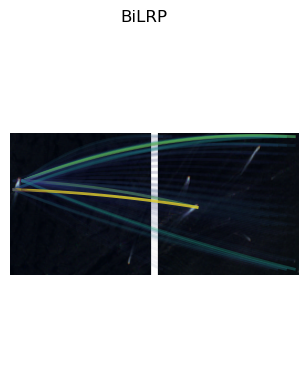

In [12]:
indices = np.indices(R.shape)
inds_all = [
    (i, R[i[0], i[1], i[2], i[3]])
    for i in indices.reshape((4, np.prod(indices.shape[1:]))).T
]


x1_rgb = x1[[0,1,2]].permute(1, 2, 0)
x2_rgb = x2[[0,1,2]].permute(1, 2, 0)

plot_relevances(inds_all, x1_rgb, coords1, x2_rgb, coords2)